# DATA5711 - Bayesian Computational Statistics

## Tutorial 4 - Part 1 - Bayesian Optimisation

**Semester 1, 11 February 2021**

**Objectives:**

* To learn about Bayesian Optimisation. 

* Exercises to be completed on IPython notebook such as: 
   * Ipython 3 (Jupyter) notebook installed on your computer http://jupyter.org/install (you need to have Python installed first https://docs.python.org/3/using/index.html )
   * Web-based Ipython notebooks such as Google Colaboratory https://colab.research.google.com/ 
   
* If you are using Jupyter intalled on your computer, Go to File->Open. Drag and drop the tutorial file file to the home interface and click upload. 
* If you are using Google Colaboratory, Click File->Upload notebook, and and upload the ".ipynb" file
* Complete exercises in ".ipynb".
* To run the cell you can press Ctrl-Enter or hit the Play button at the top.
* Complete all exercises marked with **TODO**.
* Save your file when you are done with the exercises.


Lecturers and Tutors: Roman Marchant

 ------------------------------------------------------------------------------------------------------------------

## Background Description

We will conduct Bayesian Optimisation (BO) over syntethic data. The objective is to optimise a noisy function which contains multiple local optima to show step by step how is BO reasoning, the evaluation of the acquisition function and the probabilistic model of the latent function with a GP.

We will be reusing existing Gaussian Process code and programming a simplistic version of BO.


## 0. Prepare Environment
### Import relevant packages

In [1]:
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Setting a specific random seed, to get reproducibility across students.
# @Students, you can remove or change to your own seed to try with your own training subsets.
np.random.seed(100) 

### Resuse existing Gaussian Process Code

The main differences with the GP tutorial are that:

1. The optimisation of the hyper-parameters is incorporated within the object (class).
2. The LML term has been fixed after a minor issue when overlooking an np.log.




In [2]:
class GP:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n):
        self.verbose = False
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.transpose(k_star) @ self.K_inv @ self.y_train
        f_std = self.cov_func(x_star, x_star) - np.transpose(k_star) @ self.K_inv @ k_star
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]
    
    def set_training_data(self,x,y):
        self.x_train = x
        self.y_train = y
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))

    def cov_func(self,x_1,x_2):
        if self.cov_function_name == "Squared Exponential":
            x_1_sq = np.sum(np.square(x_1),1)
            x_2_sq = np.sum(np.square(x_2),1)
            d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
            K = self.hyper_params[0]**2 * np.exp(-0.5 * d/self.hyper_params[1]**2)
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*(np.transpose(self.y_train) @ self.K_inv @ self.y_train)
        #! Very important - Last tutorial the log marginal likelihood term was missing and np.log for the determinant.
        #! Results in an over estimation of the noise
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3
    
    def fit(self):
        print("GP Optimising Hyper-parameters")
        from scipy.optimize import minimize

        def eval_params(params, gp):
            params = np.exp(params)
            gp.set_hyper_params(params[:-1],params[len(params)-1])
            nlml = -gp.log_marginal_likelihood()
            if gp.verbose:
                print(str(params)+str(nlml))
            return nlml

        x0 = np.array([np.log(2), np.log(0.8), np.log(0.3)])
        res = minimize(eval_params, x0, method='nelder-mead', args=(self),
                       options={'xatol': 1e-10, 'disp': False})
        if res.success:
            print("Optimisation results: ")
            optimal_params = np.exp(res.x)
            print("optimal_params", optimal_params)
            print("LML")
            print(self.log_marginal_likelihood())
            self.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])
        else:
            print("Error when fitting GP.")

### Plot of the objective function

The following cell defines the objective function to be optimised.

\begin{equation}
f(x) = ax^2+b\sin{cx}+\epsilon \,\,,
\end{equation}
where $a = -0.2$, $b = -0.5$, $c = 4$ and $\epsilon \sim \mathcal{N}(0,0.1^2)$

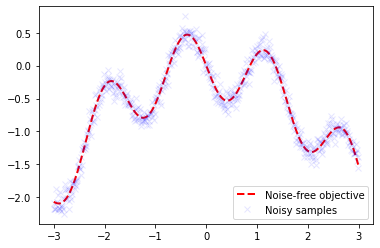

In [3]:
# Definition of the objective function
def f(X, noise=0):
    return -0.2*X**2 - 0.5*np.sin(4*X)+ noise * np.random.randn(*X.shape)

# Dense grid of points within bounds for plotting
bounds = np.array([[-3.0, 3.0]])
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

noise = 0.1 #Measurement noise for f

# Plot optimization objective with noise level 
plt.plot(X, f(X,noise=0), 'r--', lw=2, label='Noise-free objective')
plt.plot(X, f(X,noise=noise), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.legend();

### Estimate a GP regression model for $f$

1. Extract a small number of random samples from $f$ to estimate the hyper-parameters of the GP.

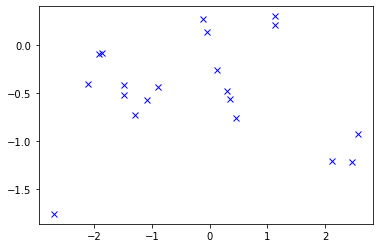

In [4]:
n_samples = 20
x_train = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=n_samples)[:,np.newaxis]
y_train = f(x_train,noise)

plt.plot(x_train, y_train, 'bx', label='Noisy samples')

2. Estimate the optimal hyperparameters of the GP model of $f$.

GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]


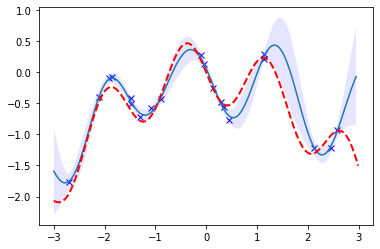

In [5]:
signal_variance = 1
lengthscale = 1
sigma_n = 1

x_star = np.arange(bounds[:, 0], bounds[:, 1], 0.05).reshape(-1, 1)

# TODO Start
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
# gp = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)
# gp.fit(x_train, y_train)
gp = GP(cov_function_name="Squared Exponential",x_train=x_train,y_train=y_train,hyper_params=[signal_variance, lengthscale], sigma_n=sigma_n)
gp.fit()
[f_mean,f_std] = gp.predict(x_star)

plt.fill_between(x_star.ravel(), (f_mean-1.96*f_std).ravel(), (f_mean+1.96*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_train, y_train, 'bx', label='Noise-free objective')
plt.plot(x_star, f_mean)
plt.plot(X, f(X,noise=0), 'r--', lw=2, label='Noise-free objective')

### Discussion

1. How valid is this approach of pre-estimating the GP hyperparameters?
2. How would you approach a problem where no initial random samples are possible?

## Bayesian Optimisation

The following cells execute bayesian optimisation, but before the core algorithm, we need to define utility functions used by the main algorithm, for evaluating the acquisition functions, maximising the acquisition function and plotting the results.

### Acquisition Functions

Expected Improvement (EI)

\begin{equation}
    EI(\mathbf{x}) = \sigma(\mathbf{x})[Z \Phi(Z)+\phi(Z)]\,\,
\end{equation}
where
\begin{equation}
    Z = \frac{\mu(\mathbf{x})-f(\mathbf{x}^+)-\xi}{\sigma(\mathbf{x})}
\end{equation}
and $\phi$, $\Phi$ are the Normal PDF and CDF respectively.

In [6]:
def EI(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X)
    mu_sample = mu

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
#       imp = mu - mu_sample_opt - xi
        imp = mu - np.random.uniform() - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

In [7]:
def ucb(X, X_sample, Y_sample, gp, kappa=1):
    ## TODO
    pass
#     return ucb_val

#### Discussion

1. How would EI behave when there is excessive noise in the function? Particularly the best sample $\mathbf{x}^+$? How would you fix this?

#### Maximise Acquisition Function

In [8]:
def arg_max_aq_func(ac_func, X_sample, Y_sample, gp, bounds, n_restarts=25):
    # Domain to evaluate the acquisition function
    x_sample_aq = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
    # Values of the acquisition function over the domain
    aq_values = ac_func(x_sample_aq, X_sample, Y_sample, gp)
    # Argmax of the acquisition funcion values
    return x_sample_aq[np.argmax(aq_values)]

#### Discussion

1. Is there a limitation of this function to higher dimensions?
2. How would you improve the maximisation of the acqusition function?

In [9]:
def plot_acquisition_function(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r.', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    

def plot_gp_regression(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X)
    plt.plot(X, Y, 'r--', lw=1, label='Noise-free objective')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    plt.plot(X_domain, mu, 'b', lw=1, label='Surrogate function')
    plt.fill_between(X_domain.ravel(), 
                     mu.ravel() + 1.96 * std.ravel(), 
                     mu.ravel() - 1.96 * std.ravel(), 
                     alpha=0.1) 
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()



GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optimising Hyper-parameters
Optimisation results: 
optimal_params [0.93094222 0.54214894 0.06288779]
LML
[[-0.68455054]]
GP Optim

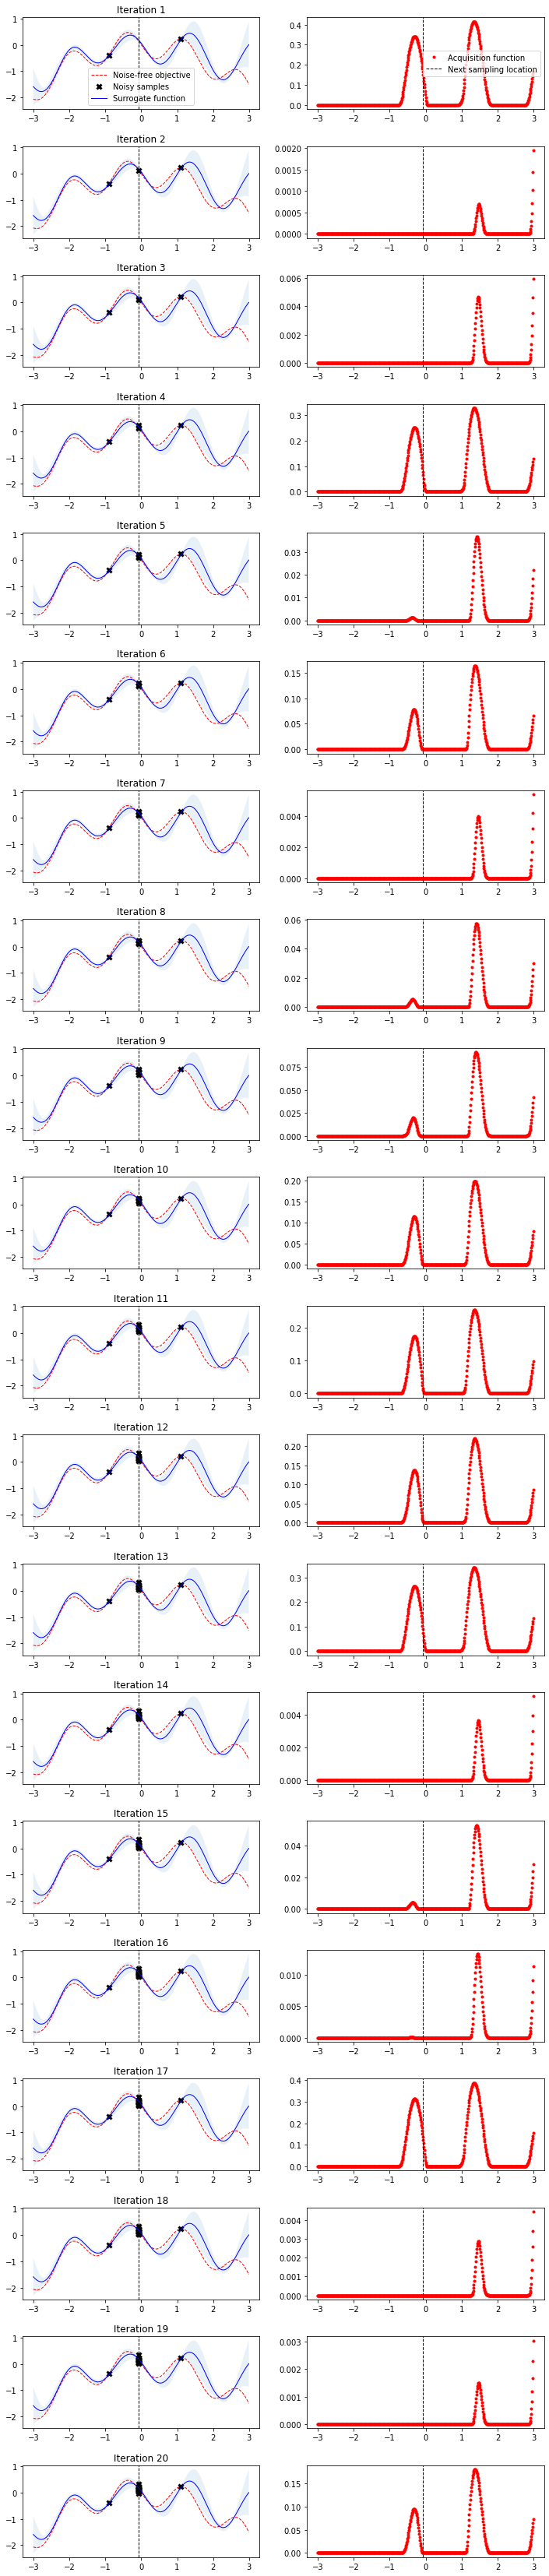

In [10]:
#perfect values of function (just for plotting)
X_domain = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
y_perfect = f(X_domain,noise=0)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

# acquisition_function
#aq_func = ucb
aq_func = EI

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    ## TODO
    # 1. Update GP
    gp.fit()

    # 2. Calculate X_next
    X_next = np.log(gp.hyper_params[0])
    
    # 3. Acquire next observation
    Y_next = f(X_next, noise=noise)
    
    # Plotting
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_gp_regression(gp, X_domain, y_perfect, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition_function(X_domain, aq_func(X_domain, X_sample, Y_sample, gp), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))